# Inference with SwinUNETR (Adapted to Semantic Segmentation)

This notebook demonstrates the inference process using the Swin UNETR model, a Swin-based transformer for 3D medical image analysis. The model is pre-trained in a self-supervised manner with proxy tasks tailored to learn underlying patterns of human anatomy, making it effective for segmentation tasks in volumetric medical images. Swin UNETR in this experiment was adapted for semantic segmentation of 2D images.

The goal of this notebook is to:
- Load a pre-trained SwinUNETR model.
- Perform segmentation
- Visualize the segmentation results.

#### DISCLAIMER
The code presented in this experiment was developed by the authors of this research, except for the pre-trained SwinUNETR model and the Shenzhen dataset, used for fine-tuning.

For more details, see the original article: [Self-Supervised Pre-Training of Swin Transformers for 3D Medical Image Analysis](https://www.semanticscholar.org/paper/Self-Supervised-Pre-Training-of-Swin-Transformers-Tang-Yang/076a8e778f2e9efb3c2fd45fed534ae9e6035f1b).

>@article{Tang2021SelfSupervisedPO,  
  title={Self-Supervised Pre-Training of Swin Transformers for 3D Medical Image Analysis},  
  author={Yucheng Tang and Dong Yang and Wenqi Li and Holger R. Roth and Bennett A. Landman and Daguang Xu and V. Nath and Ali Hatamizadeh},  
  journal={2022 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)},  
  year={2021},  
  pages={20698-20708},  
  url={https://api.semanticscholar.org/CorpusID:244715046}  
}

For more details about the dataset see: [Two public chest X-ray datasets for computer-aided screening of pulmonary diseases](https://pmc.ncbi.nlm.nih.gov/articles/PMC4256233)

>@article{jaeger2014two,  
  title={Two public chest X-ray datasets for computer-aided screening of pulmonary diseases},  
  author={Jaeger, Stefan and Candemir, Sema and Antani, Sameer and W{\'a}ng, Y{\`\i}-Xi{\'a}ng J and Lu, Pu-Xuan and Thoma, George},  
  journal={Quantitative imaging in medicine and surgery},  
  volume={4},  
  number={6},  
  pages={475},  
  year={2014}  
}

## Architecture

SwinUNETR is composed of:
- **Swin Transformer Encoder:** Uses 3D input patches and a hierarchical architecture with *shifted windowing* mechanisms to efficiently compute self-attention. This allows modeling both global and local information at different resolutions, which is crucial for volumetric images.
- **CNN-Based Decoder:** Connected to the encoder via *skip connections* at different resolutions, similar to the UNet architecture, enabling dense inference and recovery of fine spatial details.
- **Segmentation Head:** Attached at the end of the decoder to compute the final segmentation output.

![**Overview of the Swin UNETR architecture**](imgs/fig1.png)
<p align="center">Fig: Overview of the Swin UNETR architecture reproduced from original paper</p>



# Import libraries

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import random_split, Dataset, DataLoader
from PIL import Image
import random
from monai.networks.nets import SwinUNETR


seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)

# Custom Dataset Class

In [2]:
class CustomDataset(Dataset):
    def __init__(self, images_dir, mask_dir, image_transform=None, mask_transform=None, mask_type="unique"):
        self.image_names = sorted([
            f for f in os.listdir(images_dir) if f.lower().endswith(".png")
        ])
        self.images_dir = images_dir
        self.mask_type = mask_type
        self.image_transform = image_transform
        self.mask_transform = mask_transform

        if mask_type == "unique":
            self.mask_dir = mask_dir
            self.masks_names = sorted([
                f for f in os.listdir(mask_dir) if f.lower().endswith(".png")
            ])
        else:
            self.left_mask_dir = mask_dir['left_mask']
            self.right_mask_dir = mask_dir['right_mask']
            self.masks_names = sorted([
                f for f in os.listdir(mask_dir['left_mask']) if f.lower().endswith(".png")
            ])


    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.images_dir, image_name)

        image = Image.open(image_path).convert("L")

        if self.mask_type == "unique":
            mask_path = os.path.join(self.mask_dir, self.masks_names[idx])
            mask = Image.open(mask_path).convert("L")
        else:
            left_mask_path = os.path.join(self.left_mask_dir, self.masks_names[idx])
            right_mask_path = os.path.join(self.right_mask_dir, self.masks_names[idx])

            left_mask = Image.open(left_mask_path).convert("L")
            right_mask = Image.open(right_mask_path).convert("L")
            #join both masks
            mask = np.maximum(np.array(left_mask), np.array(right_mask))
            mask = Image.fromarray(mask)



        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            mask = (mask > 0).long()

        return image, mask

# Auxiliary functions

In [3]:
def create_dataset(data_paths, mask_type="unique"):
    transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            # transforms.Grayscale(num_output_channels=3),
    ])

    mask_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda x: torch.from_numpy(np.array(x)).long())
    ])

    if mask_type == "unique":
        dataset = CustomDataset(
            images_dir=data_paths['imgs'],
            mask_dir=data_paths['mask_dir'],
            image_transform=transform,
            mask_transform=mask_transforms,
            mask_type="unique"
        )
    else:
       dataset = CustomDataset(
            images_dir= data_paths['imgs'],
            mask_dir={
                "left_mask": data_paths['left'],
                "right_mask": data_paths['right']
            },
            image_transform=transform,
            mask_transform=mask_transforms,
            mask_type="dual"
        )

    return dataset

In [4]:
def create_dataloaders(dataset, batch_size):

    train_len = int(0.8 * len(dataset))
    val_len = len(dataset) - train_len
    train_dataset, val_dataset = random_split(dataset, [train_len, val_len], generator=torch.Generator().manual_seed(42))

    dataloaders={
        'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
        'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    }

    return dataloaders

# Validation Function

In [5]:
def evaluate(model, criterion, dataloaders, device):
    model.to(device)
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    running_total = 0

    with torch.no_grad():  # NO Grads
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels.squeeze(1).long())

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels).item()
            running_total += labels.numel()

    val_loss = running_loss / len(dataloaders['val'].dataset)
    val_acc = running_corrects / running_total


    return val_loss, val_acc


# Fine-Tuning Function

In [6]:
def train(model, criterion, dataloaders, optimizer, scheduler, device, epochs=25):
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_history = []
    acc_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        running_total = 0

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device).float(), labels.to(device).long()

            # Reset grads
            optimizer.zero_grad()

            #Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels.long())

                #Backward
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels).item()
            running_total += labels.numel()

        scheduler.step()
        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = running_corrects / running_total


        val_loss, val_acc = evaluate(model, criterion, dataloaders, device)
        acc_history.append(val_acc)
        loss_history.append(val_loss)

        best_model_warn = ''
        if val_acc > best_acc:
            best_model_warn = 'BEST MODEL!'
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Validation Acc: {val_acc:.4f} | {best_model_warn}")


    model.load_state_dict(best_model_wts)
    return model, loss_history, acc_history

# Downloading de Weights

In [ ]:
!wget https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/model_swinvit.pt

# Loading the Dataset
Warning: The cells below should not be executed sequentially. Run only the cell that corresponds to your case: dataset with 1 mask or dataset with 2 masks

### Dataset with 1 mask


In [7]:
dataset_path = "../../../Convolutional Neural Networks/Datasets/2D/shenzhen"
data_paths = {
    'imgs': os.path.join(dataset_path, 'images'),
    'mask_dir': os.path.join(dataset_path, 'ground_truths/both_lungs')
}
dataset = create_dataset(data_paths, mask_type="unique")

### Dataset with 2 masks

In [ ]:
dataset_path = "path/to/dataset"
data_paths = {
    'imgs': os.path.join(dataset_path, 'images'),
    'left': os.path.join(dataset_path, 'leftMask'),
    'right': os.path.join(dataset_path, 'rightMask'),
}
dataset = create_dataset(data_paths, mask_type="dual")


### Creating the Dataloaders

In [ ]:
# Define the batch size
batch_size = 4
# Create the dataloaders
dataloaders = create_dataloaders(dataset, batch_size=batch_size)

## Define Settings

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

num_classes = 2  # background and foreground

# Create model
model = SwinUNETR(
    in_channels=1,  
    out_channels=num_classes,  
    spatial_dims=2

)
# Load pre-trained weights
checkpoint = torch.load("model_swinvit.pt", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['state_dict'], strict=False)

model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# DEfine scheduler decay
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


## Freezing the layers

In [ ]:
# Freezes the entire Swin Transformer
for param in model.swinViT.parameters():
    param.requires_grad = False

# Unfreeze decoders
for decoder in [model.decoder1, model.decoder2, model.decoder3, model.decoder4, model.decoder5]:
    for param in decoder.parameters():
        param.requires_grad = True

# Unfreeze the final layer
for param in model.out.parameters():
    param.requires_grad = True


# Fine-Tuning

In [ ]:

print("Starting Fine-tuning training")

best_model, train_loss_history, val_acc_history = train(model, criterion, dataloaders, optimizer, scheduler, device, epochs=15)

Starting training
Epoch 1/15, Loss: 0.2677, Accuracy: 0.9212, Validation Acc: 0.9684 | BEST MODEL!
Epoch 2/15, Loss: 0.1152, Accuracy: 0.9717, Validation Acc: 0.9735 | BEST MODEL!
Epoch 3/15, Loss: 0.0927, Accuracy: 0.9747, Validation Acc: 0.9741 | BEST MODEL!
Epoch 4/15, Loss: 0.0833, Accuracy: 0.9758, Validation Acc: 0.9750 | BEST MODEL!
Epoch 5/15, Loss: 0.0760, Accuracy: 0.9771, Validation Acc: 0.9758 | BEST MODEL!
Epoch 6/15, Loss: 0.0722, Accuracy: 0.9774, Validation Acc: 0.9761 | BEST MODEL!
Epoch 7/15, Loss: 0.0674, Accuracy: 0.9784, Validation Acc: 0.9759 | 
Epoch 8/15, Loss: 0.0651, Accuracy: 0.9787, Validation Acc: 0.9766 | BEST MODEL!
Epoch 9/15, Loss: 0.0630, Accuracy: 0.9790, Validation Acc: 0.9762 | 
Epoch 10/15, Loss: 0.0616, Accuracy: 0.9792, Validation Acc: 0.9764 | 
Epoch 11/15, Loss: 0.0571, Accuracy: 0.9804, Validation Acc: 0.9764 | 
Epoch 12/15, Loss: 0.0555, Accuracy: 0.9809, Validation Acc: 0.9768 | BEST MODEL!
Epoch 13/15, Loss: 0.0541, Accuracy: 0.9811, Valida

## Get Sample and Run Inference

In [ ]:
def sample_and_predict(model, loader, device):
    dataset = loader.dataset

    # Pick a sample
    i = np.random.randint(len(dataset))
    sample, label = dataset[i]

    x = sample.float()

    x = x.unsqueeze(0).to(device)

    y = model(x)
    probs = torch.softmax(y, dim=1)
    confidence_map, prediction = torch.max(probs, dim=1)

    image_np = sample.squeeze().numpy()
    if image_np.ndim == 3:
        image_np = np.transpose(image_np, (1, 2, 0))

    prediction_np = prediction.squeeze(0).cpu().numpy()
    label_np = label.numpy()
    confidence = confidence_map.mean().item()

    # plot

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Input")
    plt.axis('off')
    if image_np.ndim == 2:
        plt.imshow(image_np, cmap='gray')
    else:
        plt.imshow(image_np)

    plt.subplot(1, 3, 2)
    plt.title("Prediction Overlay")
    plt.axis('off')
    plt.imshow(image_np, cmap='gray' if image_np.ndim == 2 else None)
    plt.imshow(prediction_np, cmap='tab20', alpha=0.5)

    plt.subplot(1, 3, 3)
    plt.title("Ground Truth Overlay")
    plt.axis('off')
    plt.imshow(image_np, cmap='gray' if image_np.ndim == 2 else None)
    plt.imshow(label_np, cmap='tab20', alpha=0.5)

    plt.tight_layout()
    plt.show()

    return prediction_np, confidence, i

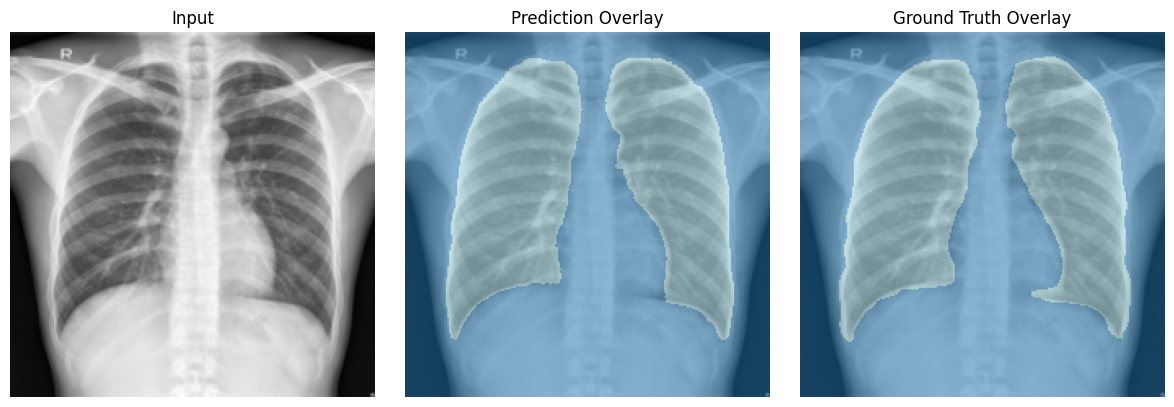


Classifier confidence: 97.72%


In [16]:
prediction, confidence, label = sample_and_predict(best_model, dataloaders['val'], device)

print( f'\nClassifier confidence: {confidence*100:4.2f}%' )